# Extract velocity values at points from nc files containing velocity maps

In [6]:
import numpy as np
import netCDF4 as nc4
import matplotlib.pyplot as plt
import pandas as pd
import fiona
from pyproj import Proj
import cmocean
import os

basepath = '/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/ASF_autoRIFT/'

In [12]:
# define projections
psProj = Proj(init='epsg:3413') # EPSG 3413 Greenland Polar Stereographic projection
utmProj = Proj("+proj=utm +zone=7 +hemisphere='N' +ellps=WGS84 +datum=WGS84 +units=m +no_defs") # Turner UTM projection

In [13]:
# important functions
def find_nearest_gridval(xcoord,ycoord,xs,ys):
    # Takes the cartesian coordinates of a point and finds the nearest grid indexes
    # in the nc raster. Assumes they are in the same coordinate system.
    import numpy as np
    
    xs=np.array(xs); ys=np.array(ys) # make sure they are arrays
    xgridval = np.nanargmin(np.abs(xs-xcoord)) # minimum difference in x
    ygridval = np.nanargmin(np.abs(ys-ycoord)) # minimum differnce in y
    
    return xgridval, ygridval

# to calculate horizontal motion
def euc_distance(x1,y1,x2,y2):
    dist = np.sqrt(((x1-x2)**2)+(y1-y2)**2)
    return dist

def myr_to_mday(array):
    return np.array(array)/365

# 1A) Extract values at points in zones

In [14]:
# read in points in zones to extract velocities from
######################################################################
zoneptpath = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/cline_points_in_zones.shp'
zone_pts = fiona.open(zoneptpath)
######################################################################
for pt in zone_pts:
    km_mark = int(30 - pt['properties']['distance']/1000)
    print(km_mark)

17
22
28
24
18
15
9
5
1


# 1B) Extract values along a centerline

In [22]:
# read in glacier centerline
cline_path = '/Users/jukesliu/Documents/TURNER/DATA/shapefiles_gis/centerlines/'
clinefile = 'centerline_n_utm07_250m.shp'

# open centerline shapefile and grab lat,lon coordinates
f = fiona.open(cline_path+clinefile)
cline_lons = []; cline_lats = []; dists = []
for pt in f:
    utmx,utmy = pt['geometry']['coordinates']
    dist_km = float(pt['properties']['distance'])/1000
    lon, lat = utmProj(utmx, utmy, inverse=True) # UTM to lat/lon
    cline_lons.append(lon); cline_lats.append(lat); dists.append(dist_km)
    
fcoords = list(zip(cline_lons, cline_lats, dists)); print(fcoords)

[(-139.8722398261982, 60.178420514546026, 2.1), (-139.84037669868803, 60.170051282502946, 4.1), (-139.80859087049657, 60.161629857994065, 6.1), (-139.78649354563623, 60.148706787996986, 8.1), (-139.78337581113635, 60.13094103038509, 10.1), (-139.79462412706533, 60.11393378811098, 12.1), (-139.79851322659042, 60.09608877617987, 14.1), (-139.79161637788786, 60.07908142606914, 16.1), (-139.7663732152516, 60.06632132066903, 18.1), (-139.73492089547693, 60.05782778510438, 20.1), (-139.70378720910085, 60.048877668270826, 22.1), (-139.67255796199686, 60.040018897253155, 24.1), (-139.6407183922356, 60.0317511169437, 26.1), (-139.60971057276785, 60.022714457403154, 28.1)]


# 2) Pull nc variables from one Sentinel-1 autoRIFT products

### 1 file:

In [16]:
filename = 'S1A_IW_SLC__1SDV_20170611T154814_20170611T154840_016988_01C490_83D0_X_S1A_IW_SLC__1SDV_20170623T154815_20170623T154841_017163_01C9E9_6950_G0120V02_P067_IL_ASF_OD.nc'
f = nc4.Dataset(basepath+filename, 'r')
list(f.variables)

['img_pair_info',
 'x',
 'y',
 'mapping',
 'vx',
 'vy',
 'v',
 'v_error',
 'vr',
 'va',
 'M11',
 'M12',
 'chip_size_width',
 'chip_size_height',
 'interp_mask']

In [17]:
f.variables['img_pair_info'].acquisition_date_img1[:8]

<ipython-input-17-2c911e9d8645>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  f.variables['img_pair_info'].acquisition_date_img1[:8]


'20170611'

In [18]:
mid_date = f.variables['img_pair_info'].date_center[:8]
dt = f.variables['img_pair_info'].date_dt
d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
print(mid_date,dt)

20170617 12.000008069814815


<ipython-input-18-0452b244fbc7>:1: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-18-0452b244fbc7>:3: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-18-0452b244fbc7>:4: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]


In [19]:
x = np.array(f.variables['x'])
y = np.array(f.variables['y'])
xgrid, ygrid = np.meshgrid(x,y)

<ipython-input-19-c096e4f5308b>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-19-c096e4f5308b>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(f.variables['y'])


In [20]:
vx = np.array(f.variables['vx'])
vy = np.array(f.variables['vy'])
vmag = np.array(f.variables['v'])
va = np.array(f.variables['va']) # azimuth velocity
vr = np.array(f.variables['vr']) # range velocity
verror = np.array(f.variables['v_error'])

<ipython-input-20-c5bd9beacd82>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vx = np.array(f.variables['vx'])
<ipython-input-20-c5bd9beacd82>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vy = np.array(f.variables['vy'])
<ipython-input-20-c5bd9beacd82>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence 

X-bounds: -3349147.5 -3271147.5
Y-bounds: 299827.5 242347.5


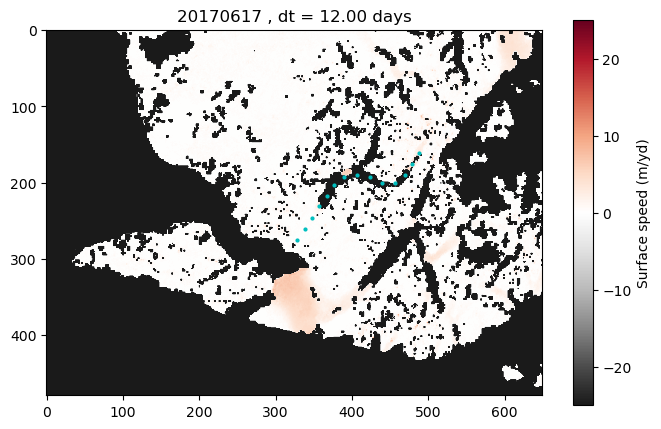

In [24]:
# subsetting the map: manually set window for subsetting (by index)
slicey1 = 1900
slicey2 = -200
slicex1 = 250
slicex2 = 900
print("X-bounds:",x[slicex1],x[slicex2])
print("Y-bounds:",y[slicey1],y[slicey2])

# plot the map
plt.figure(figsize=(8,5))
plt.imshow(myr_to_mday(vmag[slicey1:slicey2,slicex1:slicex2]), cmap='RdGy_r',vmin=-25, vmax=25)
cbar = plt.colorbar(); cbar.set_label("Surface speed (m/yd)");

# plot centerline points
# for xi,yi in fcoords: # if fcoords only contain 2 entry points
for xi,yi,dist in fcoords:
    psx,psy = psProj(xi,yi)
    xpt, ypt = find_nearest_gridval(psx,psy,x,y)
    plt.plot(xpt-slicex1, ypt-slicey1, 'c.',markersize=4)
    
plt.title(mid_date+' , dt = '+"{:.2f}".format(dt)+' days')
plt.show()

### All files:

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20200408 20200420 12.000007055486112


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


20210403 20210415 12.000005306296297
20181004 20181016 12.000004882222221


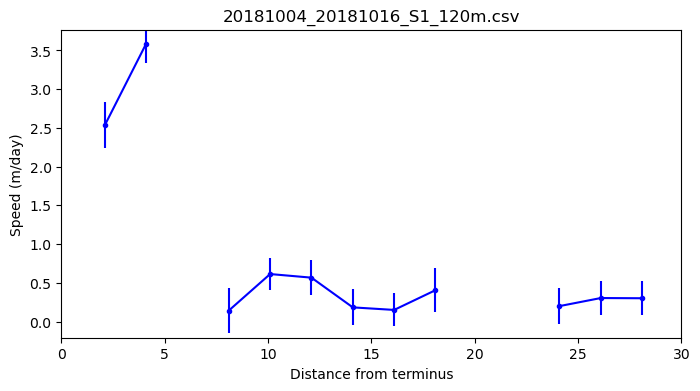

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20170915 20170927 12.00000317792824


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


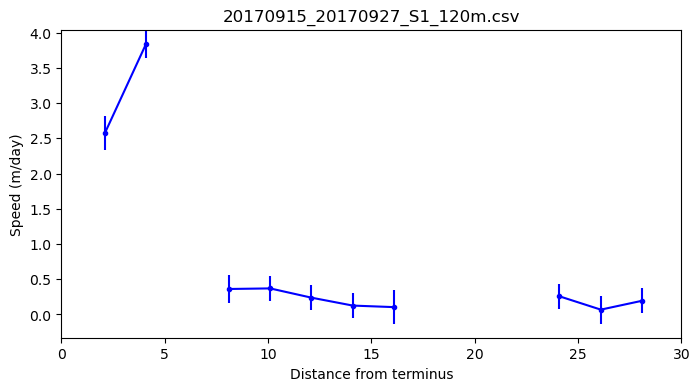

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20191210 20191222 11.99999475798611


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


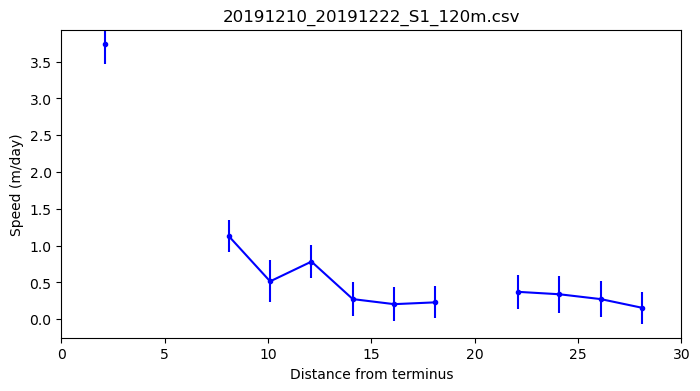

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20200701 20200713 12.000009094641204


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


20200806 20200818 12.000007832233797
20170729 20170810 12.000006208229166


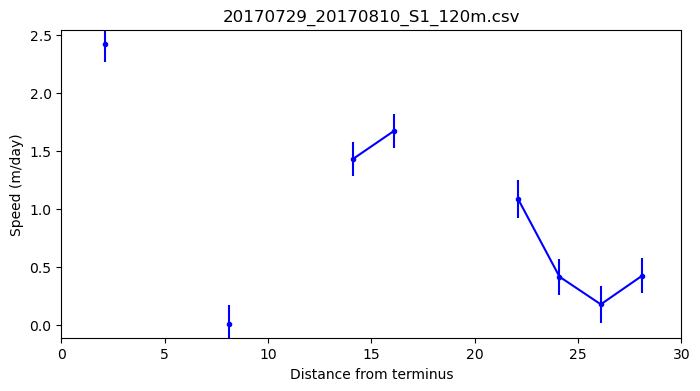

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20180125 20180206 11.999997056956019


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


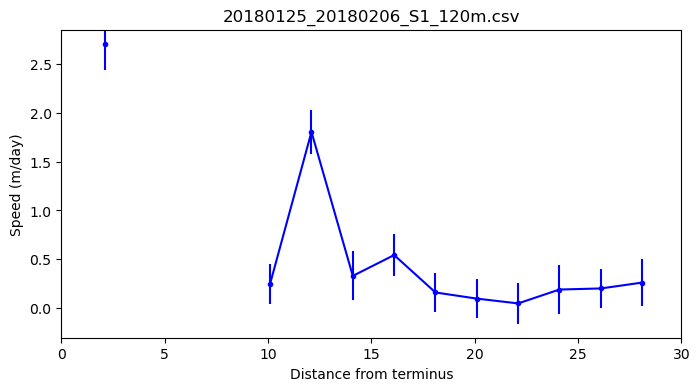

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20210813 20210825 12.000008191909721


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


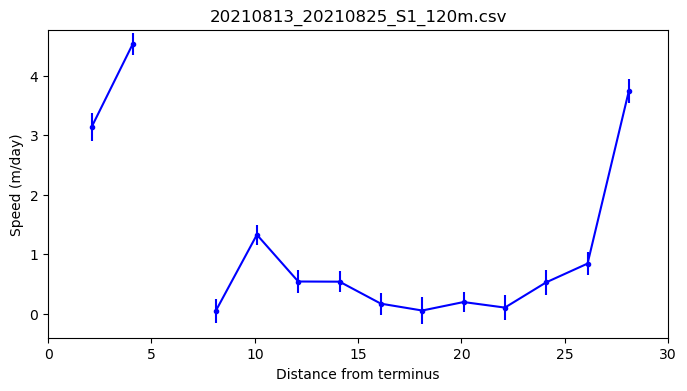

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20211024 20211105 11.999996676921297


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


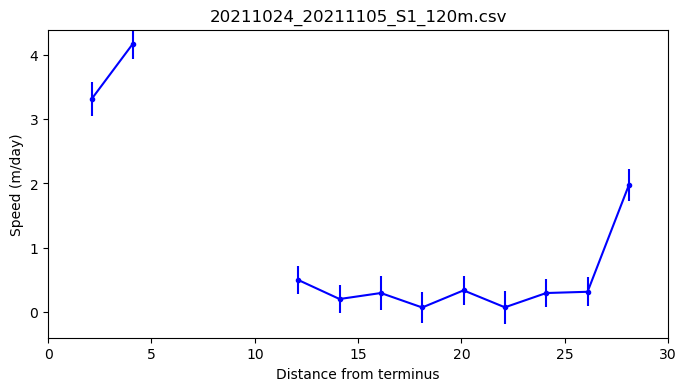

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20190414 20190426 12.000008586990742


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


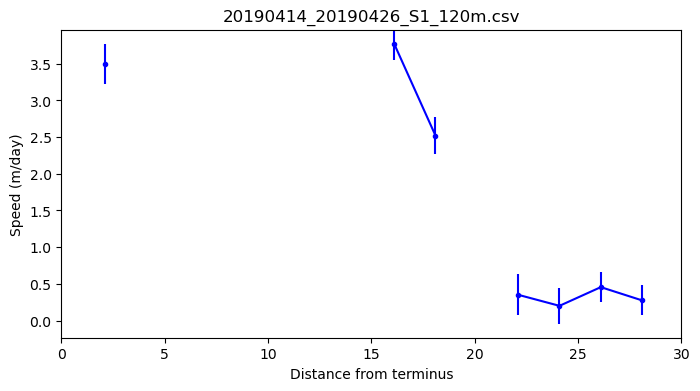

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20211129 20211211 11.999994126145834


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


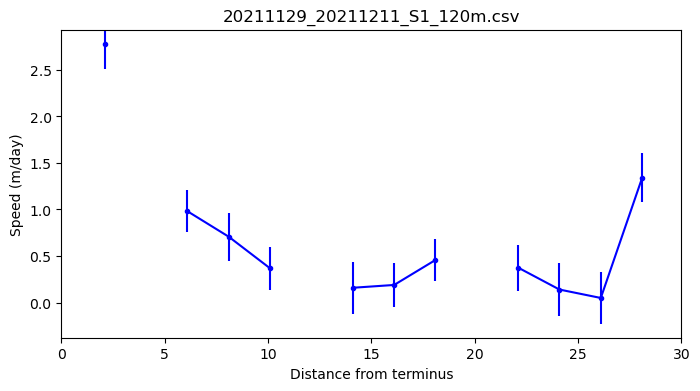

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20200420 20200502 12.000006649444444


<ipython-input-26-b44f6051abee>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vy = np.array(f.variables['vy']).astype(float)
<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for

20180206 20180218 11.999997331527778


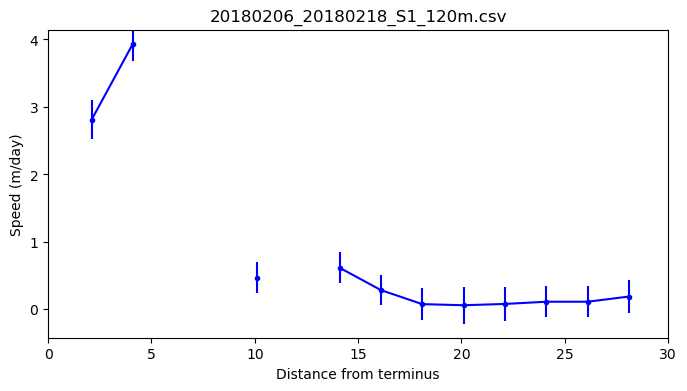

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20170301 20170313 12.00000428412037


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


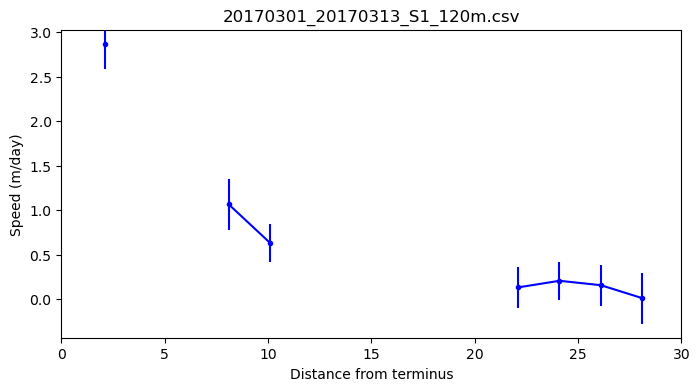

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20201204 20201216 11.999994848854167


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


20201228 20210109 11.999992361030094
20200115 20200127 11.999996115844906


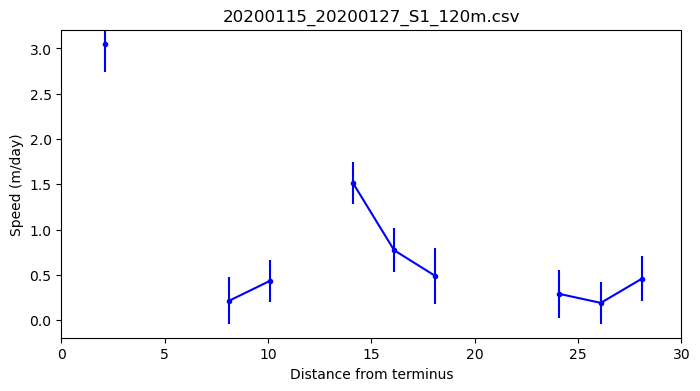

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20180326 20180407 12.00000345670139


<ipython-input-26-b44f6051abee>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vy = np.array(f.variables['vy']).astype(float)
<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for

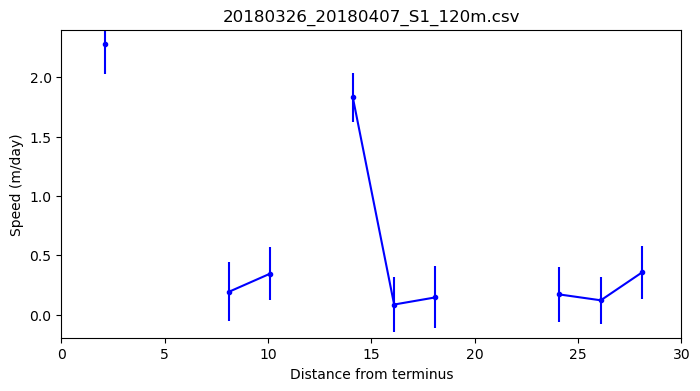

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20210918 20210930 12.000004083217593


<ipython-input-26-b44f6051abee>:25: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vx = np.array(f.variables['vx']).astype(float)
<ipython-input-26-b44f6051abee>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vy = np.array(f.variables['vy']).astype(float)
<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for 

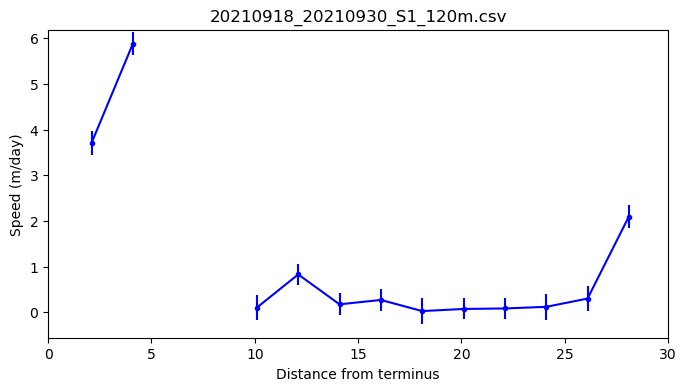

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20190402 20190414 12.000002380416667


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


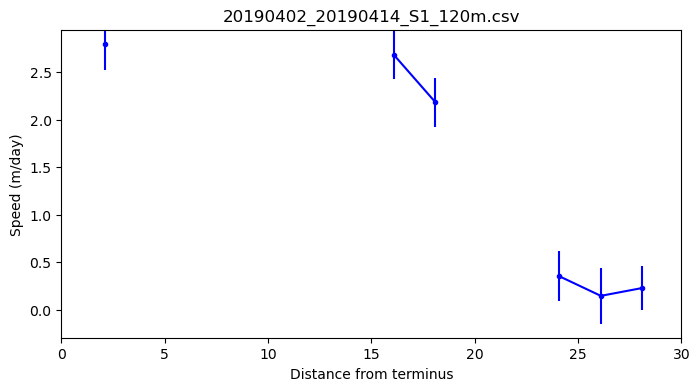

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20171021 20171102 12.000000041990742


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


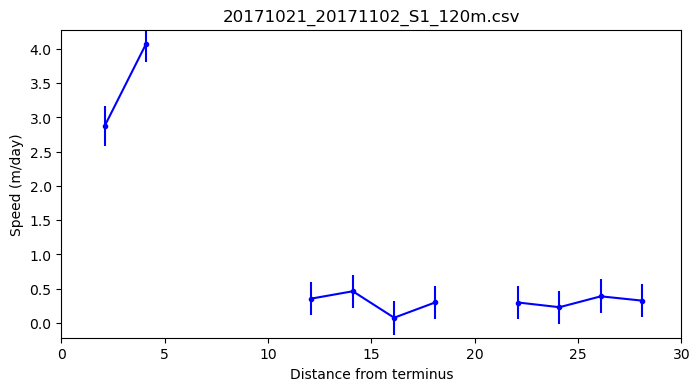

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20200526 20200607 12.000007485868055


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


20191116 20191128 11.999995340069443


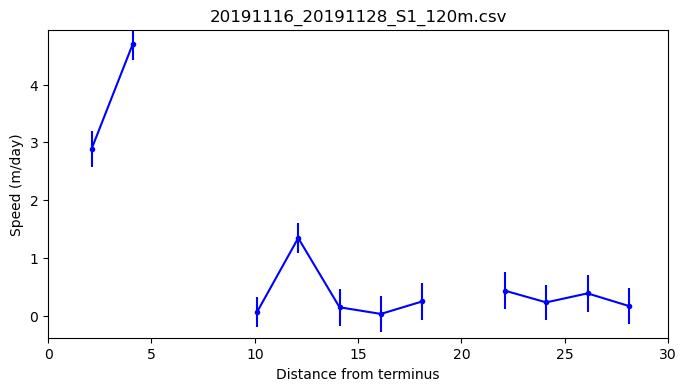

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20171114 20171126 11.999998075949074


<ipython-input-26-b44f6051abee>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vmag = np.array(f.variables['v']).astype(float)
<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


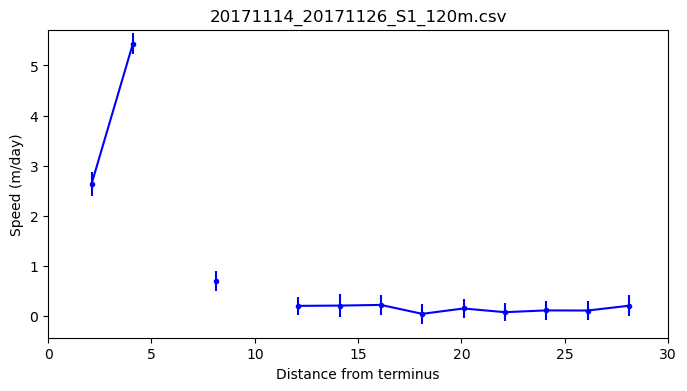

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20200103 20200115 11.999993847824074


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


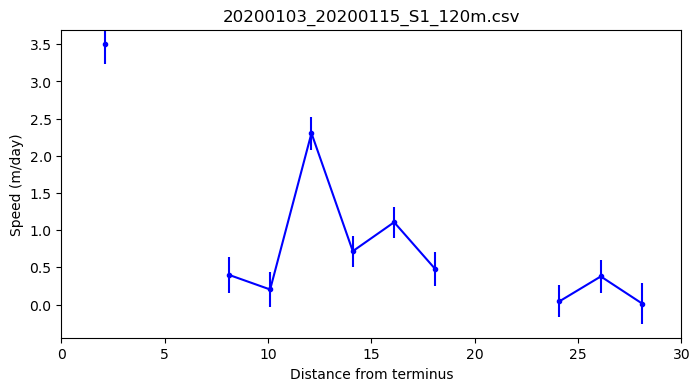

<ipython-input-26-b44f6051abee>:10: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mid_date = f.variables['img_pair_info'].date_center[:8]
<ipython-input-26-b44f6051abee>:11: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
<ipython-input-26-b44f6051abee>:12: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
<ipython-input-26-b44f6051abee>:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.array(f.variables['x'])
<ipython-input-26-b44f6051abee>:23: DeprecationWarning: `np.bool`

20210427 20210509 12.000008204328703


<ipython-input-26-b44f6051abee>:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  verror = np.array(f.variables['v_error']).astype(float)


20181016 20181028 11.999998996064814


KeyboardInterrupt: 

In [26]:
FOLDERNAME = 'speed_pts_in_zones/'

# dataFrame to match optical speed through points in zones:
ds1 = []; ds2 = []; min_chip_size = []; sat = []; err_vx = []; err_vy = []; err_v = []; 
s1 = []; s5 = []; s9 = []; s15 = []; s18 = []; s24 = []; s28 = []; s22 = []; s17 = []

for filename in os.listdir(basepath):
    if filename.startswith('S1') and filename.endswith(".nc"):
        f = nc4.Dataset(basepath+filename, 'r') # read netcdf file
        mid_date = f.variables['img_pair_info'].date_center[:8]
        d1 = f.variables['img_pair_info'].acquisition_date_img1[:8]
        d2 = f.variables['img_pair_info'].acquisition_date_img2[:8]
        dt = f.variables['img_pair_info'].date_dt
#         print(mid_date,dt)
        
        if dt <= 14: # max time separation
            print(d1, d2, dt)
#         # if the centerline data haven't already been pulled:
#         if not os.path.exists(basepath+'/centerline-values/centerline_n_'+mid_date+'_'+d1+'_'+d2+'.csv'):
            
            # pull speed map info:
            x = np.array(f.variables['x'])
            y = np.array(f.variables['y'])
#             xgrid, ygrid = np.meshgrid(x,y)
            vx = np.array(f.variables['vx']).astype(float)
            vy = np.array(f.variables['vy']).astype(float)
            vmag = np.array(f.variables['v']).astype(float)
            verror = np.array(f.variables['v_error']).astype(float)
            vmag[vmag < 0] = np.nan; verror[verror < 0] = np.nan # convert all negative values to nan
            
#             # FOR POINTS IN ZONES:
#             vmag_errs = []
#             for pt in zone_pts:
#                 [UTMx,UTMy] = pt['geometry']['coordinates'] # UTMx and y
#                 lon, lat = utmProj(UTMx, UTMy, inverse=True) # convert to lat lon
#                 psx, psy = psProj(lon, lat) # convert to Greenland polar stereographic
#                 km_mark = int(30 - pt['properties']['distance']/1000)

#                 # find closest velocity raster grid cell
#                 y_idx = np.nanargmin(np.abs(y - psy))
# #                 y_idx = vx.shape[0] - y_idx # flip the yidx
#                 x_idx = np.nanargmin(np.abs(x - psx))
#                 s = vmag[y_idx, x_idx] # grab the speed
#                 print(km_mark, s, psx, psy)
#                 v_err = verror[y_idx, x_idx] # grab the verror
#                 vmag_errs.append(v_err) # append the error
                
#                 # add the speed to the correct column
#                 if km_mark == 1:
#                     s1.append(s)
#                 elif km_mark == 5:
#                     s5.append(s)
#                 elif km_mark == 9: 
#                     s9.append(s)
#                 elif km_mark == 15:
#                     s15.append(s)
#                 elif km_mark == 18:
#                     s18.append(s)
#                 elif km_mark == 24:
#                     s24.append(s)
#                 elif km_mark == 28:
#                     s28.append(s)
#                 elif km_mark == 22:
#                     s22.append(s)
#                 elif km_mark == 17:
#                     s17.append(s)
#                 else:
#                     print(km_mark, 'km mark not recognized.')
                    
#             # calculate RMSE in vmag for all points
#             if np.count_nonzero(np.isnan(vmag_errs)) == len(vmag_errs): # if pt errors are all NaNs
#                 # then use the subset map
#                 slicey1 = 1900
#                 slicey2 = -200
#                 slicex1 = 250
#                 slicex2 = 900
#                 verr_subset = verror[slicey1:slicey2,slicex1:slicex2]
#                 err_v.append(np.sqrt(np.nanmean(verr_subset**2))/365) # calculate RMSE for subset map area
#             else:
#                 err_v.append(np.sqrt(np.nanmean(np.array(vmag_errs)**2))/365) # calculate RMSE for the points
            
#             # no vx or vy errors provided w/ ASF AutoRIFT, append NaNs
#             err_vx.append(np.NaN)
#             err_vy.append(np.NaN)
            
#             # other map information
#             ds1.append(d1); ds2.append(d2)
#             min_chip_size.append(120)
#             sat.append('S1')
            
            # FOR CENTERLINE:

            vmags = []; verrs = []; psxs = []; psys = []; dists_km = []
            # plot centerline points
            for xi,yi,dist_km in fcoords:
                psx,psy = psProj(xi, yi)
                xpt, ypt = find_nearest_gridval(psx,psy,x,y)
#                 plt.plot(xpt-slicex1, ypt-slicey1, 'c.',markersize=4)

                # append the velocity to list and coordinates
                vmags.append(vmag[ypt,xpt])
                verrs.append(verror[ypt,xpt])
                psxs.append(psx); psys.append(psy)
                dists_km.append(dist_km)


            if np.count_nonzero(~np.isnan(vmags)) >= len(fcoords)/3: # if at least one-third of the 
                # centerline points have data, save to file in a folder
                v_df = pd.DataFrame(list(zip(dists_km, vmags, verrs, cline_lons, cline_lats, psxs, psys)),
                                  columns=['dist_km','vmag','v_error','lon','lat','PSx','PSy'])
                v_df.to_csv(basepath+FOLDERNAME+d1+'_'+d2+'_S1_120m.csv')
                
                # plot profile along centerline
                plt.figure(figsize=(8,4))
                plt.errorbar(v_df.dist_km,myr_to_mday(v_df.vmag),yerr=v_df['v_error'].fillna(0)/365,fmt='b.-')
                plt.title(d1+'_'+d2+'_S1_120m.csv')
                plt.xlim(0,30); plt.xlabel("Distance from terminus")
                plt.ylabel("Speed (m/day)");
                plt.savefig(basepath+FOLDERNAME+d1+'_'+d2+'_S1_120m.png')
                plt.show()

# # FOR SPEED IN PTS ONLY        
# df = pd.DataFrame(list(zip(ds1, ds2, min_chip_size, sat, err_vx, err_vy, err_v, 
#                            s1, s5, s9, s15, s18, s24, s28, s22, s17)), 
#                   columns=['ds1','ds2','min_chip_size','sat','err_vx','err_vy','err_v','s1','s5','s9',
#                           's15','s18','s24','s28','s22','s17'])
# df.to_csv('/Users/jukesliu/Documents/TURNER/DATA/VELOCITY_MAPS/speed_timeseries_thru_pts_S1.csv')
# df

## Old code:

In [2]:
# # Pull data along centerline
# all_dfs = []
# for file in os.listdir(basepath+'/centerline-values/'):
#     if file.startswith('centerline_s') and file.endswith('csv'):
#         # grab dates
#         mid_date = file[13:21]
#         d1 = file[22:30]; ds1 = d1[:4]+'-'+d1[4:6]+'-'+d1[-2:]; 
#         d2 = file[31:39]; ds2 = d2[:4]+'-'+d2[4:6]+'-'+d2[-2:];
        
#         # read in df
#         cp = basepath+'/centerline-values/'+file
#         df = pd.read_csv(cp)
        
#         # grab distance along centerline, add dates and distance back into the df
#         dist_kms = []; middates = []; d1s = []; d2s = []
#         for i in range(0, len(df.PSx)):
#             if i == 0: # first value
#                 dist_km = 0
#             elif i < len(df.PSx)-1:
#                 x1, y1 = utmProj(df.lon[i],df.lat[i])
#                 x2, y2 = utmProj(df.lon[i+1],df.lat[i+1])
            
#                 dist_km = euc_distance(x1,y1,x2,y2)/1000 # calculate distances between points in km
                
#             dist_kms.append(dist_km)
#             middates.append(mid_date)
#             d1s.append(ds1)
#             d2s.append(ds2)

#         df['dist_km'] = np.flip(np.cumsum(dist_kms))
#         df['mid_date'] = middates
#         df['ds1'] = d1s
#         df['ds2'] = d2s
        
#         # plot profile along centerline
#         plt.figure(figsize=(8,4))
#         plt.errorbar(df.dist_km,myr_to_mday(df.vmag),yerr=df['v_error'].fillna(0)/365,fmt='b.-')
#         plt.title(mid_date)
#         plt.xlim(0,30); plt.xlabel("Distance from terminus")
#         plt.ylim(0,10); plt.ylabel("Speed (m/day)");
#         plt.savefig(basepath+'/figures/'+mid_date+'_'+d1+'_'+d2+'_centerline_prof.png')
#         plt.show()
        
#         all_dfs.append(df)
        
# # concatenate all dfs
# total_df = pd.concat(all_dfs)
# total_df


In [3]:
# # plot centerline time series
# total_df

In [4]:
# sorted_df = total_df.sort_values(by=['mid_date','ds1','dist_km'])
# sorted_df

In [5]:
# sorted_df.to_csv(basepath+'centerline_data_s.csv')

In [61]:
# # BedMachine bathymetry
# bedz = np.array(f.variables['bed'])
# errbed = np.array(f.variables['errbed'])
# mask = np.array(f.variables['mask'])

# plt.imshow(mask)
# plt.colorbar()
# plt.show()

In [62]:
# # bounds to subset the raster
# east = 164898
# west = 183338
# upper = -2885395
# lower = -2904120

In [63]:
# ycoords = []; xcoords = [];
# yidxs = []; xidxs = []
# for ybound in [upper, lower]:
#     print(ybound)
#     mindiffy = np.amin(np.abs(ygrid-ybound)) # find the minimum difference between the bound and a ycoord
#     ycoord = ygrid[np.abs(ygrid-ybound) == mindiffy]
#     ycoords.append(ycoord[0])
#     yidx = np.where(np.abs(ygrid-ybound) == mindiffy)[0][0]
#     yidxs.append(yidx)

# for xbound in [east, west]:
#     print(xbound)
#     mindiffx = np.amin(np.abs(xgrid-xbound)) # find the minimum difference between the bound and a ycoord
#     xcoord = xgrid[np.abs(xgrid-xbound) == mindiffx]
#     xcoords.append(xcoord[0])
#     xidx = np.where(np.abs(xgrid-xbound) == mindiffx)[1][0]
#     xidxs.append(xidx)

In [64]:
# bedz_subset = bedz[yidxs[0]:yidxs[1], xidxs[0]:xidxs[1]]
# plt.imshow(bedz_subset)
# plt.colorbar()
# plt.show()

Pull depths at glacier termini:

In [65]:
# termini_df = pd.read_csv('/Users/jukesliu/Documents/AUTO-TERMINUS/Nature_Science_paper/SM/SM_fjord_glaciers_Box118_Box123.csv',
#                          header =0,names = ['ID','BoxID','path','bd','lat','lon','Easting','Northing'])

In [66]:
# termini_df

In [67]:
# new_df = pd.DataFrame(list([85355],[-3215722]), columns=['Easting','Northing'])

In [68]:
# x = 85355
# y = -3215722
# mindiffy = np.amin(np.abs(ygrid-y)) # find the minimum difference between the coordinate and a gridline
# yidx = np.where(np.abs(ygrid-y) == mindiffy)[0][0]
    
# mindiffx = np.amin(np.abs(xgrid-x)) # find the minimum difference between the coordinate and a gridline
# xidx = np.where(np.abs(xgrid-x) == mindiffx)[1][0]
    
# depth = bedz[yidx,xidx]
# err = errbed[yidx,xidx]
# print(str(depth),f'\u00B1',str(err))

In [69]:
# depths = []
# errors = []
# for i in range(0, len(termini_df.Easting)):
#     x = termini_df.Easting[i]
#     y = termini_df.Northing[i]
#     print(x,y)
    
#     mindiffy = np.amin(np.abs(ygrid-y)) # find the minimum difference between the coordinate and a gridline
#     yidx = np.where(np.abs(ygrid-y) == mindiffy)[0][0]
    
#     mindiffx = np.amin(np.abs(xgrid-x)) # find the minimum difference between the coordinate and a gridline
#     xidx = np.where(np.abs(xgrid-x) == mindiffx)[1][0]
    
#     depth = bedz[yidx,xidx]
#     err = errbed[yidx,xidx]
    
#     depths.append(depth)
#     errors.append(err)

In [70]:
# for j in range(0, len(depths)):
#     print(str(depths[j]),f'\u00B1',str(errors[j]))

In [71]:
# errors

In [72]:
# errbed